# Versuch E01 - Grundpraktikum Elektronik

In [68]:
%matplotlib inline

from uncertainties import unumpy,umath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from scipy.optimize import curve_fit, minimize

#print(plt.style.available)

In [2]:
def plotformat(xlabel='x', ylabel='y', xscale='linear', yscale='linear',\
             title='graph', filename='tmp', style='bmh', yticks=[], xticks=[],\
             formatter=tck.ScalarFormatter):
    
    plt.figure(figsize=(15,10))
    ax = plt.gca()
    plt.style.use(style)
    
    #plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.')
    
    plt.xscale(xscale)
    plt.yscale(yscale)
        
    #ax.yaxis.set_major_formatter(tck.LogFormatter())
    
    for label in ax.yaxis.get_major_ticks():
        label.
        print(label.label1)
    
    if len(yticks) > 0:
        plt.yticks(yticks)
        plt.axes().get_yaxis().set_major_formatter(formatter())
    if len(xticks) > 0:
        plt.xticks(xticks)
        plt.axes().get_xaxis().set_major_formatter(formatter())
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    #plt.savefig(filename+'.png')

In [29]:
def fitfunc(freq, vumax, n1, n2, s1, s2):
    return vumax/(np.sqrt(1+(freq/s1)**n1)*np.sqrt(1+(freq/s2)**n2))
def fitfunc2(f, sx1, sx2, ox1, oy):
    #-sy*np.e**(-(sx1*f)-ox1)-
    return oy - np.e**(sx1*(-f+ox1)) - np.e**(sx2*f)+oy

## V1 - Emitterschaltung

In [4]:
data = np.genfromtxt('1-freq.dat', dtype=float, skip_header=0, delimiter=',')[2:]

# Inbetriebnahme und Vermessung
init = np.array([6.79,0.615,7.94,0.997,0.387,7.20])
init*.05/100+.001

array([ 0.004395 ,  0.0013075,  0.00497  ,  0.0014985,  0.0011935,  0.0046   ])

Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')


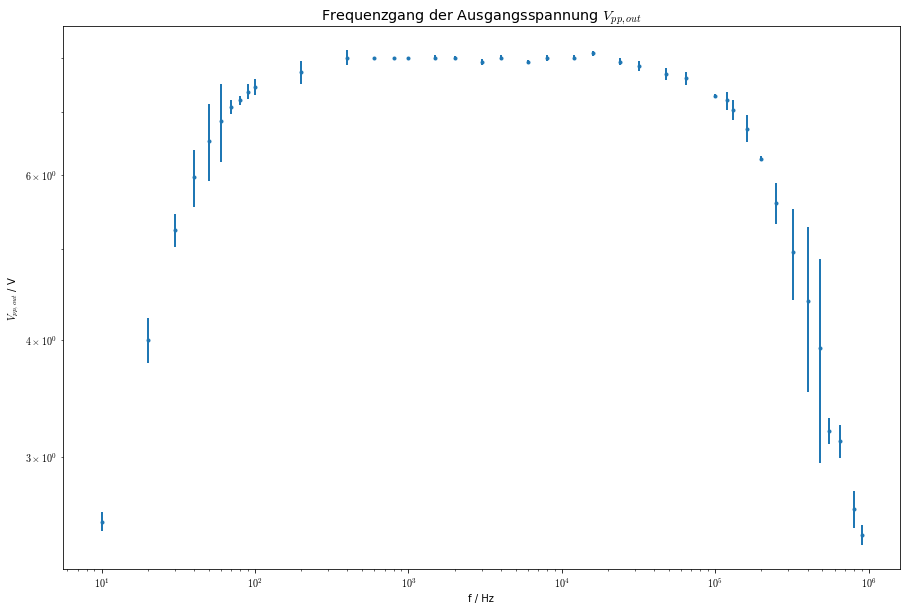

In [5]:
plotformat(xlabel='f / Hz', ylabel='$V_{pp,out}$ / V', xscale='log', yscale='log',\
        title='Frequenzgang der Ausgangsspannung $V_{pp,out}$')
plt.errorbar(data[:,0], data[:,4], xerr=data[:,1], yerr=data[:,5], fmt='.')
plt.savefig('1-freqU.png')

Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
18.7441594033
0.213354155725
22.4573193783


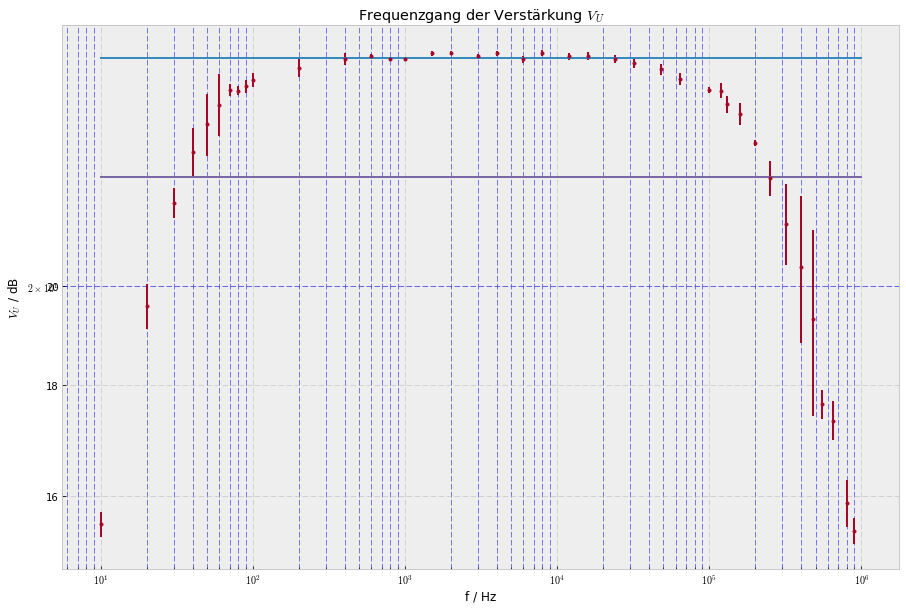

In [95]:
vppin = unumpy.uarray(data[:,2],data[:,3])
vppout = unumpy.uarray(data[:,4],data[:,5])

verst = vppout/vppin*1000

# 200Hz - 64kHz
mean_verst = np.sum(unumpy.nominal_values(verst)[10:26])/16
mean_verst_dev = np.sum(unumpy.std_devs(verst)[10:26])/16
plotformat(xlabel='f / Hz', ylabel='$V_U$ / dB',\
           xscale='log', yscale='log',\
           title='Frequenzgang der Verstärkung $V_U$',\
           yticks=[6,8,10,12,14,16,18,20])
        
fitdata = np.logspace(1,6,1E3)
db = lambda x: 20*np.log10(x)
plt.plot(fitdata, db([mean_verst for i in range(len(fitdata))]))
plt.errorbar(data[:,0], db([verst[i].n for i in range(len(verst))]),\
             xerr=data[:,1],\
             yerr=db(unumpy.nominal_values(verst)+unumpy.std_devs(verst)) - db(unumpy.nominal_values(verst)), fmt='.')
plt.plot(fitdata, db([mean_verst for i in range(len(fitdata))])-3)
plt.grid(b=True, which='minor', color='', linestyle='--')
print(mean_verst)
print(mean_verst_dev)
print(db(mean_verst)-3)
plt.savefig('1-freqU.png')
#pd.DataFrame(verst)

## V2 - Kollektorschaltung

In [ ]:
init = np.array([7.69,0.64,6.78,8.31])
init*.05/100+.001

In [ ]:
data2 = np.genfromtxt("2-freq.dat", dtype=float, skip_header=0, delimiter=',')[2:]

plotfreq(data2[:,0], data2[:,4], xerr=data2[:,1], yerr=data2[:,5],\
         xscale="log", yscale="log", xlabel="f / Hz", ylabel="$V_{pp,out} / mV$",\
         title="Frequenzgang der Ausgangsspannung $V_{pp,out}$",\
         filename='2-freqU', yticks=[450, 500, 550, 600])
plt.clf()

In [ ]:
vppout = unumpy.uarray(data2[:,4],data2[:,5])
vppin = unumpy.uarray(data2[:,2],data2[:,3])

verst = vppout/vppin

plotfreq(data2[:,0], [verst[i].n for i in range(len(verst))],\
         yerr=[verst[i].s for i in range(len(verst))], xerr=data2[:,1],\
         xscale="log", yscale="log", yticks=[.95+i*.05 for i in range(6)],\
         xlabel="f / Hz", ylabel="$V_U$", title="Frequenzgang der Verstärkung $V_U$",\
         filename='2-freqV')
plt.clf()
#pd.DataFrame(verst)